# 사이킷런을 이용한 토픽 모델링

**데이터 준비**

In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 
              'comp.sys.ibm.pc.hardware', 'sci.crypt']

# 학습 데이터셋을 가져옴
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

print('Train set size:', len(newsgroups_train.data))
print('Selected categories:', newsgroups_train.target_names)

Train set size: 3219
Selected categories: ['alt.atheism', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'sci.space', 'talk.religion.misc']


In [2]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english', 
                     max_features=2000, min_df=5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data) 

**LDA 토픽 모델링 실행**

In [3]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
np.set_printoptions(precision=3)

lda = LatentDirichletAllocation(n_components = 10, # 추출할 topic의 수
                                max_iter=5,         # 알고리즘 최대 반복 횟수
                                topic_word_prior=0.1, doc_topic_prior=1.0,  # 각각 β, α (둘다 기본값 1/n_components)
                                learning_method='online', 
                                n_jobs= -1,     # 사용 processor 수 (가능한 모든 프로세서 사용)
                                random_state=0)

review_topics = lda.fit_transform(review_cv)
print('shape of review_topics:', review_topics.shape)   # θ에 해당
print('Sample of review_topics:', review_topics[0])

gross_topic_weights = np.mean(review_topics, axis=0)
print('Sum of topic weights of documents:', gross_topic_weights)

print('shape of topic word distribution:', lda.components_.shape)   # ϕ에 해당

shape of review_topics: (3219, 10)
Sample of review_topics: [0.901 0.007 0.029 0.008 0.007 0.008 0.008 0.007 0.007 0.019]
Sum of topic weights of documents: [0.09  0.083 0.081 0.114 0.117 0.136 0.085 0.072 0.072 0.151]
shape of topic word distribution: (10, 2000)


In [4]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()

print_top_words(lda,cv.get_feature_names_out(), 10)

Topic #0: com, morality, keith, article, sgi, think, sandvik, caltech, objective, moral
Topic #1: image, graphics, file, files, ftp, available, software, use, data, pub
Topic #2: space, access, launch, earth, orbit, digex, lunar, shuttle, satellite, com
Topic #3: article, com, just, like, don't, university, i'm, nntp, host, posting
Topic #4: key, clipper, chip, encryption, com, government, law, keys, use, escrow
Topic #5: scsi, com, posting, nntp, host, thanks, bit, university, ibm, know
Topic #6: nasa, gov, university, host, posting, nntp, ___, distribution, center, washington
Topic #7: drive, com, disk, hard, controller, drives, dos, tape, problem, floppy
Topic #8: key, public, mail, faq, message, pgp, group, des, posting, university
Topic #9: god, people, don't, jesus, just, believe, say, does, think, know



**최적의 토픽 수 선택하기**

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1,    # max_iter 너무 낮추면 perplexity가 높아지고 토픽 수에 비례함
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components = i, max_iter=max_iter, 
                                        topic_word_prior= topic_word_prior, 
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)    
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

n_components: 6, perplexity: 1063.362
n_components: 7, perplexity: 1045.636
n_components: 8, perplexity: 1015.561
n_components: 9, perplexity: 1016.494
n_components: 10, perplexity: 1028.560
n_components: 11, perplexity: 1036.692
n_components: 12, perplexity: 1032.437
n_components: 13, perplexity: 1038.319
n_components: 14, perplexity: 1040.664
n_components: 15, perplexity: 1046.556


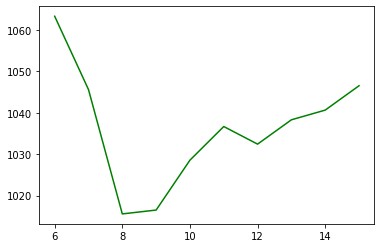

n_components with minimum perplexity: 8


In [6]:
print("n_components with minimum perplexity:",
      show_perplexity(review_cv, start=6, end=15))

In [7]:
lda = LatentDirichletAllocation(n_components = 8, # 추출할 topic의 수를 지정
                                max_iter=20, 
                                topic_word_prior= 0.1, 
                                doc_topic_prior=1.0,
                                learning_method='batch',    # online 보다 성능이 좋고 느리다.
                                n_jobs= -1, 
                                random_state=7)

review_topics = lda.fit_transform(review_cv)

print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: image, graphics, mail, available, file, ftp, data, files, software, information
Topic #1: nasa, gov, posting, space, university, host, nntp, ___, center, distribution
Topic #2: com, keith, article, morality, think, posting, nntp, caltech, don't, host
Topic #3: com, article, jesus, know, just, posting, host, nntp, don't, i'm
Topic #4: people, god, does, don't, think, say, believe, just, way, like
Topic #5: drive, scsi, card, com, disk, thanks, ide, controller, bus, hard
Topic #6: space, access, article, launch, just, year, like, digex, moon, com
Topic #7: key, encryption, clipper, chip, com, government, keys, use, security, public

